## HW 3: Q-learning
_Reference: based on Practical RL course by YSDA_

In this notebook you have to master Q-learning and apply it to RL problems once again.

To get used to `gymnasium` package, please, refer to the [documentation](https://gymnasium.farama.org/introduction/basic_usage/).


In the end of the notebook, please, copy the functions you have implemented to the template file and submit it to the Contest.

In [61]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Step 1: Tabular Q-learning with SoftMax policy

We want you to implement Q-learning algorithm with softmax policy.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

SoftMax policy means that actions probabilities are computed from q-values using softmax function, where $\tau$ is the softmax temperature:

$$ \pi(a_i \mid s) = \operatorname{softmax} \left( \left\{ {Q(s, a_j) \over \tau} \right\}_{j=1}^n \right)_i = {\operatorname{exp} \left( Q(s,a_i) / \tau \right)  \over {\sum_{j}  \operatorname{exp} \left( Q(s,a_j) / \tau  \right)}} $$

First, implement softmax. Do not forget that exponent of large value might be too big to fit in float. Substract maximum for numerical stability.

In [62]:
def my_softmax(values: np.ndarray, T=1.):
    probas = np.exp((values-max(values))/T)/np.sum(np.exp((values-max(values))/T))
    assert probas is not None
    return probas

Now check your Softmax using the following tests.

In [63]:
import torch
test_data = np.arange(5)
for temp in [0.1, 0.5, 1, 5]:
  local_softmax = my_softmax(test_data, T=temp)
  with torch.no_grad():
    torch_softmax = torch.softmax(torch.from_numpy(test_data)/temp, dim=-1)
  assert np.allclose(local_softmax, torch_softmax.numpy())
  print(f'Passed for temp={temp}')
  print(local_softmax, torch_softmax)

Passed for temp=0.1
[4.24816138e-18 9.35719813e-14 2.06106005e-09 4.53978686e-05
 9.99954600e-01] tensor([4.2482e-18, 9.3572e-14, 2.0611e-09, 4.5398e-05, 9.9995e-01])
Passed for temp=0.5
[2.90075868e-04 2.14338686e-03 1.58376057e-02 1.17024957e-01
 8.64703974e-01] tensor([2.9008e-04, 2.1434e-03, 1.5838e-02, 1.1702e-01, 8.6470e-01])
Passed for temp=1
[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865] tensor([0.0117, 0.0317, 0.0861, 0.2341, 0.6364])
Passed for temp=5
[0.12885125 0.15737927 0.19222347 0.23478228 0.28676373] tensor([0.1289, 0.1574, 0.1922, 0.2348, 0.2868])


Simple visualization for your convenience

Text(0.5, 1.0, 'Example softmax with temp = 1')

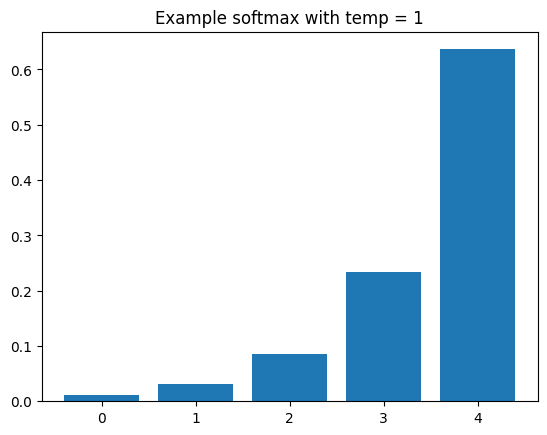

In [64]:
temp = 1
plt.bar(test_data, my_softmax(test_data, T=temp))
plt.title(f'Example softmax with temp = {temp}')

Now implement the `QLearningAgent`. You will solve several environments using it and later submit to the Contest.

In [66]:
import random
from collections import defaultdict


class QLearningAgent:
    def __init__(self, alpha, discount, get_legal_actions, temp=1.):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly.
            There's a special self.get_qvalue/set_qvalue for that.
        """
        self.epsilon = 0.26  # exploration prob
        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.discount = discount
        self.temp = temp

    def get_qvalue(self, state, action):
        """Returns Q(state,action)"""
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """Sets the Qvalue for [state,action] to the given value"""
        self._qvalues[state][action] = value

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        # YOUR CODE HERE
        # Calculate the approximation of value function V(s).
        value = max([self.get_qvalue(state, a) for a in possible_actions])
        assert value is not None

        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        # YOUR CODE HERE
        # Calculate the updated value of Q(s, a).
        qvalue = (1-learning_rate)*self.get_qvalue(state,action)+learning_rate*(reward+gamma*self.get_value(next_state))
        assert qvalue is not None

        self.set_qvalue(state, action, qvalue)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # YOUR CODE HERE
        # Choose the best action wrt the qvalues.
        best_action = max(possible_actions, key=lambda a: self.get_qvalue(state,a))
        assert best_action is not None

        return best_action

    def get_softmax_policy(self, state):
        """
        Compute all actions probabilities in the current state according
        to their q-values using softmax policy.

        Actions probability should be computed as
        p(a_i|s) = softmax([q(s, a_1), q(s, a_2), ... q(s, a_k)])_i
        Softmax temperature is set to `self.temp`.
        See the formula in the notebook for more details
        """
        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # YOUR CODE HERE
        # Compute all actions probabilities in the current state using softmax
        q_values = np.array([self.get_qvalue(state, a) for a in possible_actions])
        assert q_values is not None
        probabilities = my_softmax(q_values, T=self.temp)


        assert probabilities is not None

        return probabilities


    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.
        Select actions according to softmax policy.

        Note: To pick randomly from a list, use np.random.choice(..., p=actions_probabilities)
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """
        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None
        action = None
        # YOUR CODE HERE
        # Select the action to take in the current state according to the policy
        epsilon = self.epsilon

        if random.random() < epsilon:
            action = random.choice(possible_actions)
        else:   
            action = self.get_best_action(state)

        assert action is not None
        return action

### Try it on taxi

Here we use the Q-Learning agent on the Taxi-v3 environment from OpenAI gym.
You will need to complete a few of its functions.

In [67]:
import gymnasium as gym

env = gym.make("Taxi-v3", render_mode="rgb_array")

n_actions = env.action_space.n

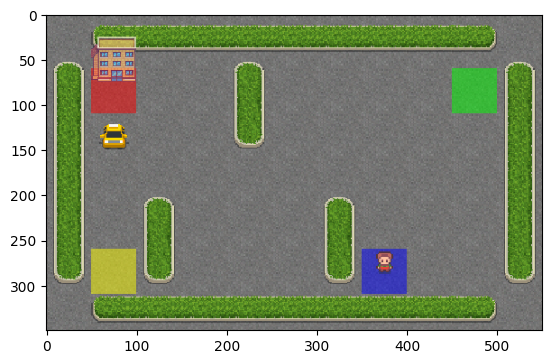

In [68]:
s, _ = env.reset()
plt.imshow(env.render())

In [69]:
agent = QLearningAgent(alpha=0.5, discount=0.99, get_legal_actions=lambda s: range(n_actions))

In [21]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s, _ = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _, _ = env.step(a)

        # train (update) agent for state s
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

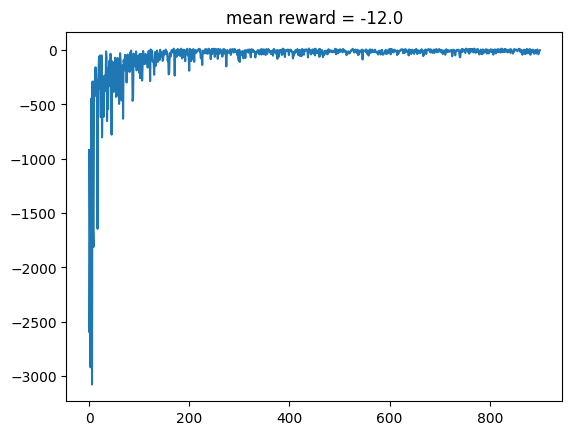

In [70]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))

    if i % 100 == 0:
        clear_output(True)
        plt.title("mean reward = {:.1f}".format(np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.show()

# Step 2: Discretized state spaces.

Let's try solving the same `CartPole-v1` problem using Tabular Q-learning.

This environment has a continuous set of possible states, so we will have to group them into bins somehow.

Simple binarization is already present. You can play with to see what happens.

The simplest way is to use `round(x, n_digits)` (or `np.round`) to round a real number to a given amount of digits. The tricky part is to get the `n_digits` right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

first state: [-0.03026373 -0.04969677  0.03836676  0.04907274]


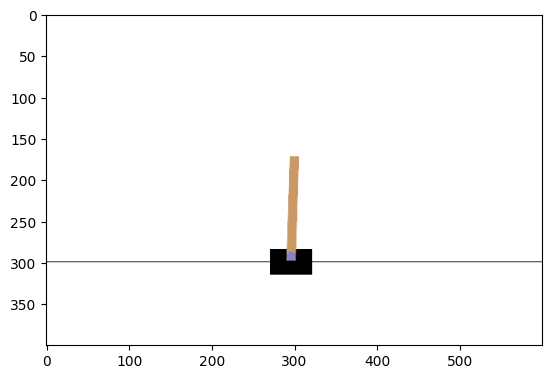

In [71]:
def make_env():
    return gym.make("CartPole-v1", render_mode="rgb_array")


env = make_env()
n_actions = env.action_space.n

print("first state: %s" % (env.reset()[0]))
plt.imshow(env.render())

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

In [72]:
def visualize_cartpole_observation_distribution(seen_observations):
    seen_observations = np.array(seen_observations)

    # The meaning of the observations is documented in
    # https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

    f, axarr = plt.subplots(2, 2, figsize=(16, 9), sharey=True)
    for i, title in enumerate(["Cart Position", "Cart Velocity", "Pole Angle", "Pole Velocity At Tip"]):
        ax = axarr[i // 2, i % 2]
        ax.hist(seen_observations[:, i], bins=20)
        ax.set_title(title)
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(min(xmin, -xmax), max(-xmin, xmax))
        ax.grid()
    f.tight_layout()

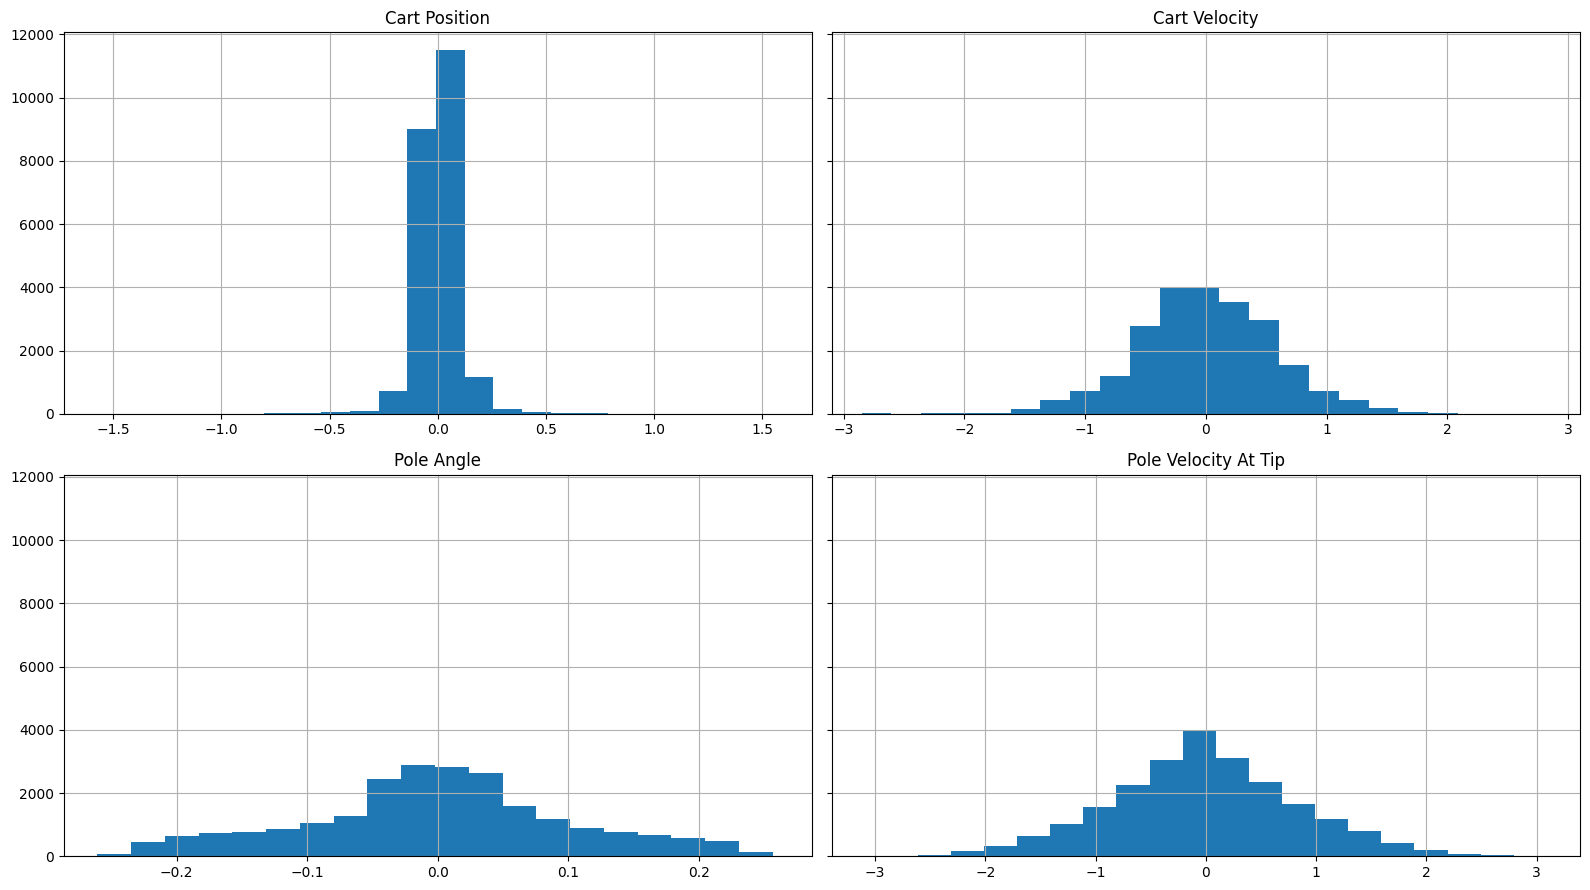

In [73]:
seen_observations = []
for _ in range(1000):
    s, _ = env.reset()
    seen_observations.append(s)
    done = False
    while not done:
        s, r, done, _, _ = env.step(env.action_space.sample())
        seen_observations.append(s)

visualize_cartpole_observation_distribution(seen_observations)

## Discretize environment

In [74]:
from gymnasium.core import ObservationWrapper


class Discretizer(ObservationWrapper):
    def observation(self, state):
        # Hint: you can do that with round(x, n_digits).
        # You may pick a different n_digits for each dimension.

        features_ndigits = [1, 1, 1, 1]
        for feature_index in range(len(state)):
            state[feature_index] = round(state[feature_index], features_ndigits[feature_index])

        return tuple(state)

In [75]:
env = Discretizer(make_env())

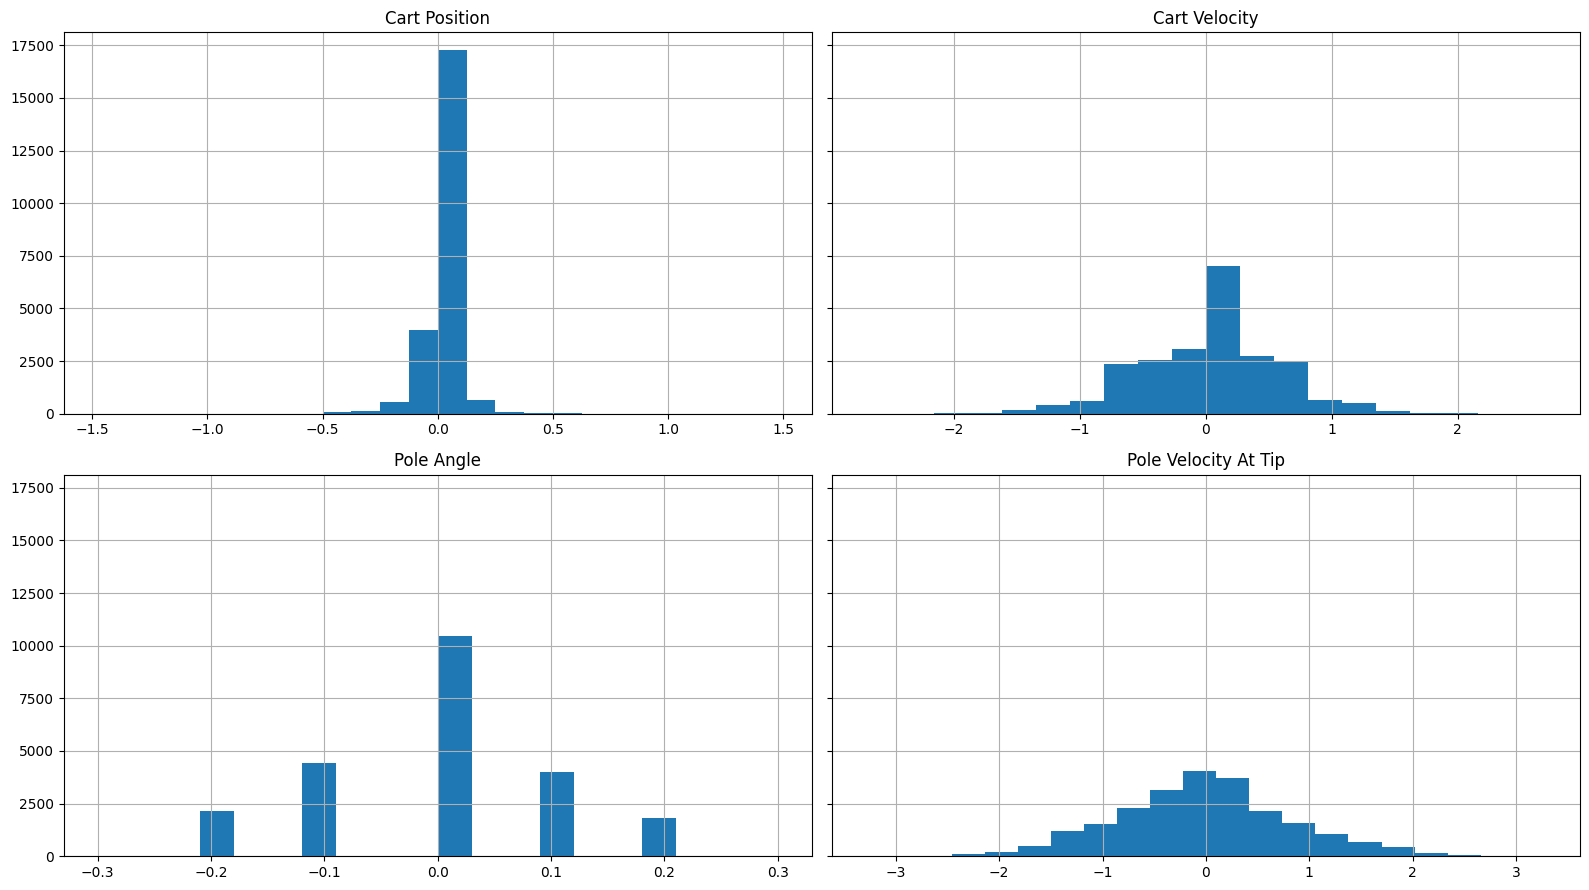

In [76]:
seen_observations = []
for _ in range(1000):
    s, _ = env.reset()
    seen_observations.append(s)
    done = False
    while not done:
        s, r, done, _, _ = env.step(env.action_space.sample())
        seen_observations.append(s)
        if done:
            break

visualize_cartpole_observation_distribution(seen_observations)

## Learn discretized policy

Now let's train a policy that uses discretized state space.

__Tips:__

* Note that increasing the number of digits for one dimension of the observations increases your state space by a factor of $10$.
* If your discretization is too fine-grained, your agent will take much longer than 10000 steps to converge. You can either increase the number of iterations and reduce epsilon decay or change discretization. In practice we found that this kind of mistake is rather frequent.
* If your discretization is too coarse, your agent may fail to find the optimal policy. In practice we found that on this particular environment this kind of mistake is rare.
* **Start with a coarse discretization** and make it more fine-grained if that seems necessary.
* Having $10^3$–$10^4$ distinct states is recommended (`len(agent._qvalues)`), but not required.
* If things don't work without annealing $\varepsilon$, consider adding that, but make sure that it doesn't go to zero too quickly.

A reasonable agent should attain an average reward of at least 50.

In [77]:
import pandas as pd


def moving_average(x, span=100):
    return pd.DataFrame({"x": np.asarray(x)}).x.ewm(span=span).mean().values

In [78]:
agent = QLearningAgent(alpha=0.5, discount=0.99, get_legal_actions=lambda s: range(n_actions))

In [79]:
rewards = []


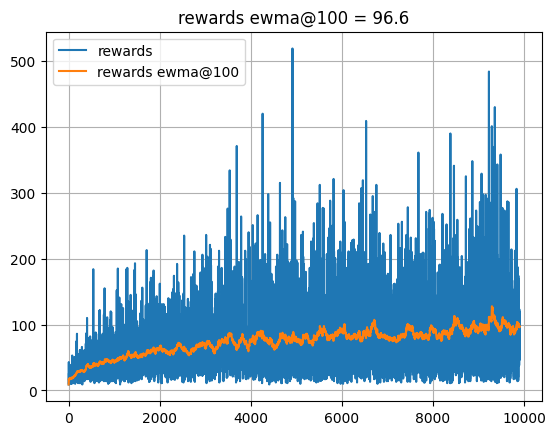

In [80]:

for i in range(10000):
    reward = play_and_train(env, agent)
    rewards.append(reward)

    if i % 100 == 0:
        rewards_ewma = moving_average(rewards)

        clear_output(True)
        plt.plot(rewards, label="rewards")
        plt.plot(rewards_ewma, label="rewards ewma@100")
        plt.legend()
        plt.grid()
        plt.title("rewards ewma@100 = {:.1f}".format(rewards_ewma[-1]))
        plt.show()

In [81]:
print("Your agent has learned {} Q-values.".format(len(agent._qvalues)))

Your agent has learned 12847 Q-values.


## Step 3: EV-SARSA with softmax policy

The policy we're going to use is still softmax, but now the state  value is computed differently.

We inherit from the existing implementation of `QLearningAgent` and only update the `get_value` method.

In [82]:
class EVSarsaAgent(QLearningAgent):
    """
    An agent that changes some of q-learning functions to implement Expected Value SARSA.
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for Expected Value SARSA's V(s')
    """

    def get_value(self, state):
        """
        Returns Vpi for current state under the softmax policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}

        Hint: all other methods from QLearningAgent are still accessible.
        """
        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        # YOUR CODE HERE
        # Compute the value of the current state under the softmax policy.
        value = sum([self.get_softmax_policy(state)[a]*self.get_qvalue(state,a) for a in possible_actions])
        assert value is not None

        return value

### Cliff World

Let's now see how our algorithm compares against q-learning in case where we force agent to explore all the time.

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/cliffworld.png width=600>
<center><i>Image from CS188</i></center>

In [83]:
env = gym.make("CliffWalking-v1", render_mode="rgb_array")
n_actions = env.action_space.n

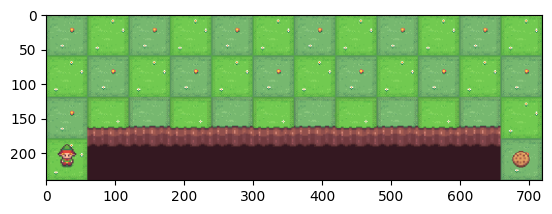

In [84]:
# Our cliffworld has one difference from what's in the image: there is no wall.
# Agent can choose to go as close to the cliff as it wishes.
# x:start, T:exit, C:cliff, o: flat ground

env.reset()
plt.imshow(env.render())

In [85]:
agent_sarsa = EVSarsaAgent(alpha=0.25, discount=0.99, get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, discount=0.99, get_legal_actions=lambda s: range(n_actions))

EVSARSA mean reward = -124.09
QLEARNING mean reward = -106.03


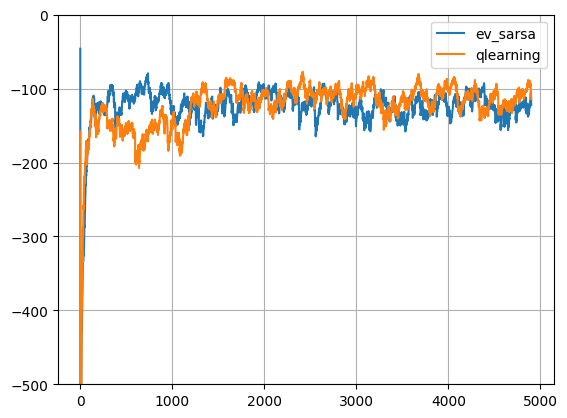

In [86]:
from IPython.display import clear_output


def moving_average(x, span=100):
    return pd.DataFrame({"x": np.asarray(x)}).x.ewm(span=span).mean().values


rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))

    if i % 100 == 0:
        clear_output(True)
        print("EVSARSA mean reward =", np.mean(rewards_sarsa[-100:]))
        print("QLEARNING mean reward =", np.mean(rewards_ql[-100:]))
        plt.plot(moving_average(rewards_sarsa), label="ev_sarsa")
        plt.plot(moving_average(rewards_ql), label="qlearning")
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

Let's now see what did the algorithms learn by visualizing their actions at every state.

In [87]:
def draw_policy(agent):
    """Prints CliffWalkingEnv policy with arrows. Hard-coded."""

    env = gym.make("CliffWalking-v1", render_mode="ansi")
    env.reset()
    grid = [x.split("  ") for x in env.render().split("\n")[:4]]

    n_rows, n_cols = 4, 12
    start_state_index = 36
    actions = "^>v<"

    for yi in range(n_rows):
        for xi in range(n_cols):
            if grid[yi][xi] == "C":
                print(" C ", end="")
            elif (yi * n_cols + xi) == start_state_index:
                print(" X ", end="")
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end="")
            else:
                print(" %s " % actions[agent.get_best_action(yi * n_cols + xi)], end="")
        print()

In [88]:
print("Q-Learning")
draw_policy(agent_ql)

print("SARSA")
draw_policy(agent_sarsa)

Q-Learning
 >  v  v  v  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  v  v  v  v 
 >  >  >  >  >  >  >  >  >  >  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


Congratulations! Finally, copy the `QLearningAgent`, `EVSarsaAgent` and `my_softmax` to the template and submit them to the Contest.

Good luck!

In [90]:
np.dot(np.matrix([50,100,150,200]),np.matrix([[1,2],[-1,2],[0,2],[1,-1]]))

matrix([[150, 400]])